## 지역 관점으로 EDA
- 지역별로는 어떻게 봐야할까?
    - 좌표는 달려있음
        - Reverse Geocoding : 위도/경도 => 주소로 변환
        - API를 날려야할까?
        - BigQuery GIS엔 shp 파일을 Join해서 찾아내는 기능이 있음

- Shp 파일
    - `bigquery-public-data.geo_us_boundaries.zip_codes`에 저장됨
    - pickup_longitude, pickup_latitude가 zip_code_geom에 속하면 그 지역
- BigQuery GIS
    - [공식 문서](https://cloud.google.com/bigquery/docs/gis-intro?hl=ko)
    - [Geography functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

In [1]:
import chart_studio.plotly as py
import cufflinks as cf    # wrapper
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
print(cf.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
cf.go_offline()

0.17.3


In [2]:
%%time
# base_data : yellow taxi의 1월 운행 기록만 추출한 임시 테이블
# temp : base_data 테이블과 zip_codes 테이블을 inner join한 임시 테이블
#        (join 조건 : geopoint 좌표가 zip_code_geom의 multipolygon 영역에 포함되어 있어야 함.)
# latitude 90 -> 북극, -90 -> 남극

query = """
WITH base_data AS (
  SELECT *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1    
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df = pd.read_gbq(query=query, dialect='standard', project_id='nyc-taxi-demand')

Downloading: 100%|███████████████████| 87020/87020 [01:21<00:00, 1069.06rows/s]

Wall time: 2min 5s


In [3]:
df.head(10)

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,10152,New York city,"POLYGON((-73.972613 40.759059, -73.973068 40.7...",2015-01-01,15
1,11237,New York city,"POLYGON((-73.934802 40.713373, -73.934534 40.7...",2015-01-01,38
2,10280,New York city,"POLYGON((-74.019596 40.705638, -74.019603 40.7...",2015-01-01,54
3,11225,New York city,"POLYGON((-73.964786 40.662054, -73.965025 40.6...",2015-01-01,10
4,10453,New York city,"POLYGON((-73.92815 40.845507, -73.928159 40.84...",2015-01-01,4
5,10199,New York city,"MULTIPOLYGON(((-73.99725 40.752083, -73.99768 ...",2015-01-01,20
6,11101,New York city,"POLYGON((-73.96262 40.739033, -73.962609 40.73...",2015-01-01,96
7,10803,"Pelham village, New Rochelle city, Pelham Mano...","POLYGON((-73.823264 40.891357, -73.823244 40.8...",2015-01-01,1
8,10467,New York city,"POLYGON((-73.895986 40.886397, -73.895424 40.8...",2015-01-01,1
9,11424,New York city,"POLYGON((-73.830934 40.714322, -73.830982 40.7...",2015-01-01,2


### 운행(출발하는 곳) 빈도가 높은 zip_code는?

In [7]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index().sort_values(by=['cnt'],ascending=False)

In [8]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
33,10036,"POLYGON((-74.001537 40.761487, -74.001622 40.7...",598936
20,10023,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",463049
14,10017,"POLYGON((-73.981372 40.752814, -73.981822 40.7...",439631
18,10021,"MULTIPOLYGON(((-73.959493 40.758974, -73.95972...",428487


In [9]:
# 운행 횟수의 비율 정보를 데이터프레임에 추가
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3)

In [10]:
zip_code_agg_df.tail()

,zip_code,zip_code_geom,cnt,percent
328,11720,"POLYGON((-73.109394 40.854903, -73.109474 40.8...",1,0.0
329,11722,"POLYGON((-73.231195 40.803989, -73.231339 40.8...",1,0.0
330,11726,"POLYGON((-73.409227 40.68468, -73.409242 40.68...",1,0.0
331,11729,"POLYGON((-73.354085 40.765347, -73.354342 40.7...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [11]:
zip_code_agg_df.head()

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053


In [12]:
# percent value가 0.000 보다 큰 행만 필터링하여 새로운 데이터프레임 구성
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

In [13]:
filter_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
51,10154,"POLYGON((-73.973068 40.758432, -73.973524 40.7...",11168,0.001
186,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",10907,0.001
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
29,10032,"POLYGON((-73.950279 40.834326, -73.949932 40.8...",8765,0.001
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001
44,10111,"POLYGON((-73.97845 40.759065, -73.978039 40.75...",6898,0.001


In [14]:
# csv 파일 생성
filter_agg_df.to_csv("zip_code_ratio.csv", index=False)

### Kepler.gl에서 시각화
- [Kepler.gl](https://kepler.gl/demo)
- ![NewYork_Geometry_Kepler](kepler1.png)

- ![NewYork_Geometry_Kepler2](kepler2.png)

In [15]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]

In [16]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

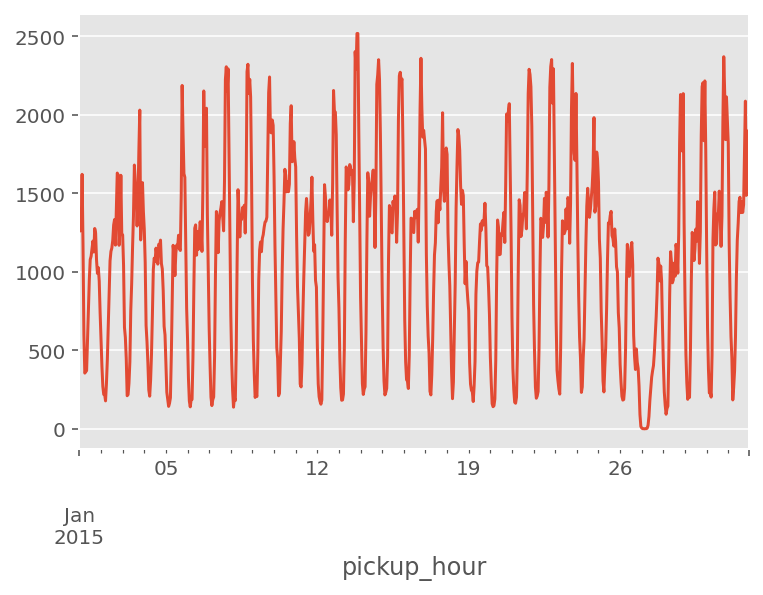

In [18]:
zip_df[zip_df['zip_code'] == '10019'].set_index('pickup_hour')['cnt'].plot()

### 하루 단위 zip_code별 Trip Box Plot

In [19]:
zip_df

,zip_code,zip_code_geom,pickup_hour,cnt,date
0,10152,"POLYGON((-73.972613 40.759059, -73.973068 40.7...",2015-01-01 00:00:00,15,2015-01-01
1,11237,"POLYGON((-73.934802 40.713373, -73.934534 40.7...",2015-01-01 00:00:00,38,2015-01-01
2,10280,"POLYGON((-74.019596 40.705638, -74.019603 40.7...",2015-01-01 00:00:00,54,2015-01-01
3,11225,"POLYGON((-73.964786 40.662054, -73.965025 40.6...",2015-01-01 00:00:00,10,2015-01-01
4,10453,"POLYGON((-73.92815 40.845507, -73.928159 40.84...",2015-01-01 00:00:00,4,2015-01-01
...,...,...,...,...,...
87015,11375,"POLYGON((-73.858522 40.721529, -73.858235 40.7...",2015-01-31 23:00:00,2,2015-01-31
87016,11207,"POLYGON((-73.916046 40.686072, -73.915827 40.6...",2015-01-31 23:00:00,2,2015-01-31
87017,10013,"POLYGON((-74.016302 40.720758, -74.016381 40.7...",2015-01-31 23:00:00,841,2015-01-31
87018,11228,"POLYGON((-74.027369 40.613235, -74.02755 40.61...",2015-01-31 23:00:00,1,2015-01-31


In [22]:
# percent value가 0.000 보다 큰 zip code를 리스트로 저장
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [24]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]
filter_zip_df.head(10)

,zip_code,zip_code_geom,pickup_hour,cnt,date
0,10152,"POLYGON((-73.972613 40.759059, -73.973068 40.7...",2015-01-01,15,2015-01-01
2,10280,"POLYGON((-74.019596 40.705638, -74.019603 40.7...",2015-01-01,54,2015-01-01
5,10199,"MULTIPOLYGON(((-73.99725 40.752083, -73.99768 ...",2015-01-01,20,2015-01-01
6,11101,"POLYGON((-73.96262 40.739033, -73.962609 40.73...",2015-01-01,96,2015-01-01
10,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01,1221,2015-01-01
11,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45,2015-01-01
12,10168,"POLYGON((-73.977677 40.752119, -73.978159 40.7...",2015-01-01,32,2015-01-01
13,10023,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",2015-01-01,971,2015-01-01
17,10035,"MULTIPOLYGON(((-73.946325 40.800852, -73.94646...",2015-01-01,92,2015-01-01
18,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",2015-01-01,432,2015-01-01


In [25]:
# 일자 별, zip code별 운행 빈도 수 합산을 한 데이터프레임
filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()
filter_zip_daily_df.head(10)

,zip_code,date,cnt
0,10001,2015-01-01,16770
1,10001,2015-01-02,17046
2,10001,2015-01-03,20478
3,10001,2015-01-04,16743
4,10001,2015-01-05,17441
5,10001,2015-01-06,18544
6,10001,2015-01-07,20846
7,10001,2015-01-08,22799
8,10001,2015-01-09,21773
9,10001,2015-01-10,25343


In [30]:
filter_zip_daily_df.pivot_table(values='cnt', index='date', columns='zip_code', aggfunc=np.mean)

zip_code,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11206,11211,11215,11217,11222,11231,11238,11371,11377,11430
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,16770,9703,21226,2137,1485,1656,2868,10049,10306,15644,...,1302,5150,1120,1458,1479,656,1043,6401,828,7400
2015-01-02,17046,5538,18452,1972,1234,1405,2437,7158,9334,16040,...,165,1218,238,522,219,278,204,8316,374,8225
2015-01-03,20478,10507,26384,1560,1290,1575,2358,10918,11338,20606,...,314,2310,369,827,440,528,360,7381,403,8507
2015-01-04,16743,9067,19516,1182,964,993,1844,8098,8738,15877,...,338,1931,366,673,353,347,336,10917,396,10287
2015-01-05,17441,3769,16264,1921,1475,956,2438,5213,10431,16002,...,164,1064,253,630,210,359,181,11369,450,11463
2015-01-06,18544,4086,17745,1798,1735,938,2502,5373,11680,17649,...,162,1086,291,485,232,419,156,8592,382,8751
2015-01-07,20846,4990,21063,2277,1939,1158,3056,6488,13315,20367,...,193,1301,349,798,249,514,190,8083,402,7828
2015-01-08,22799,5483,22227,2470,2032,1199,3293,6481,14207,21880,...,175,1402,373,597,252,523,221,8953,419,7483
2015-01-09,21773,7195,23696,2299,2087,1069,3234,7949,14140,22150,...,250,1767,391,753,406,547,286,8484,476,7935


In [29]:
filter_zip_daily_df.pivot_table(values='cnt', index='date', columns='zip_code', aggfunc=np.mean).iplot(kind='box', x='zip_code')

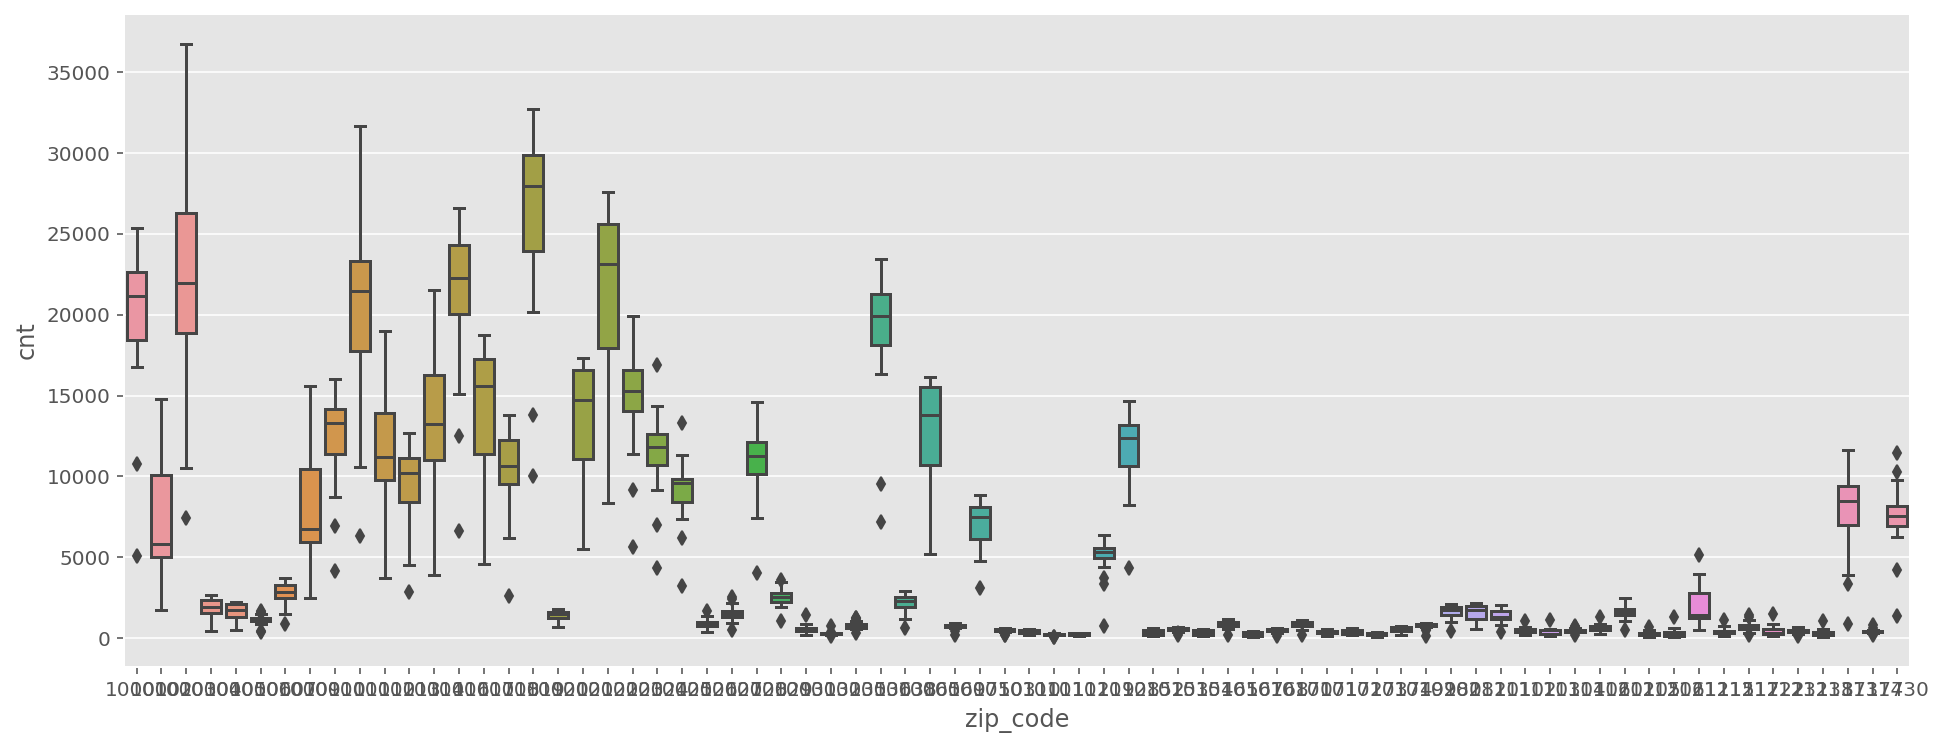

In [31]:
plt.figure(figsize=(16, 6));
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df)

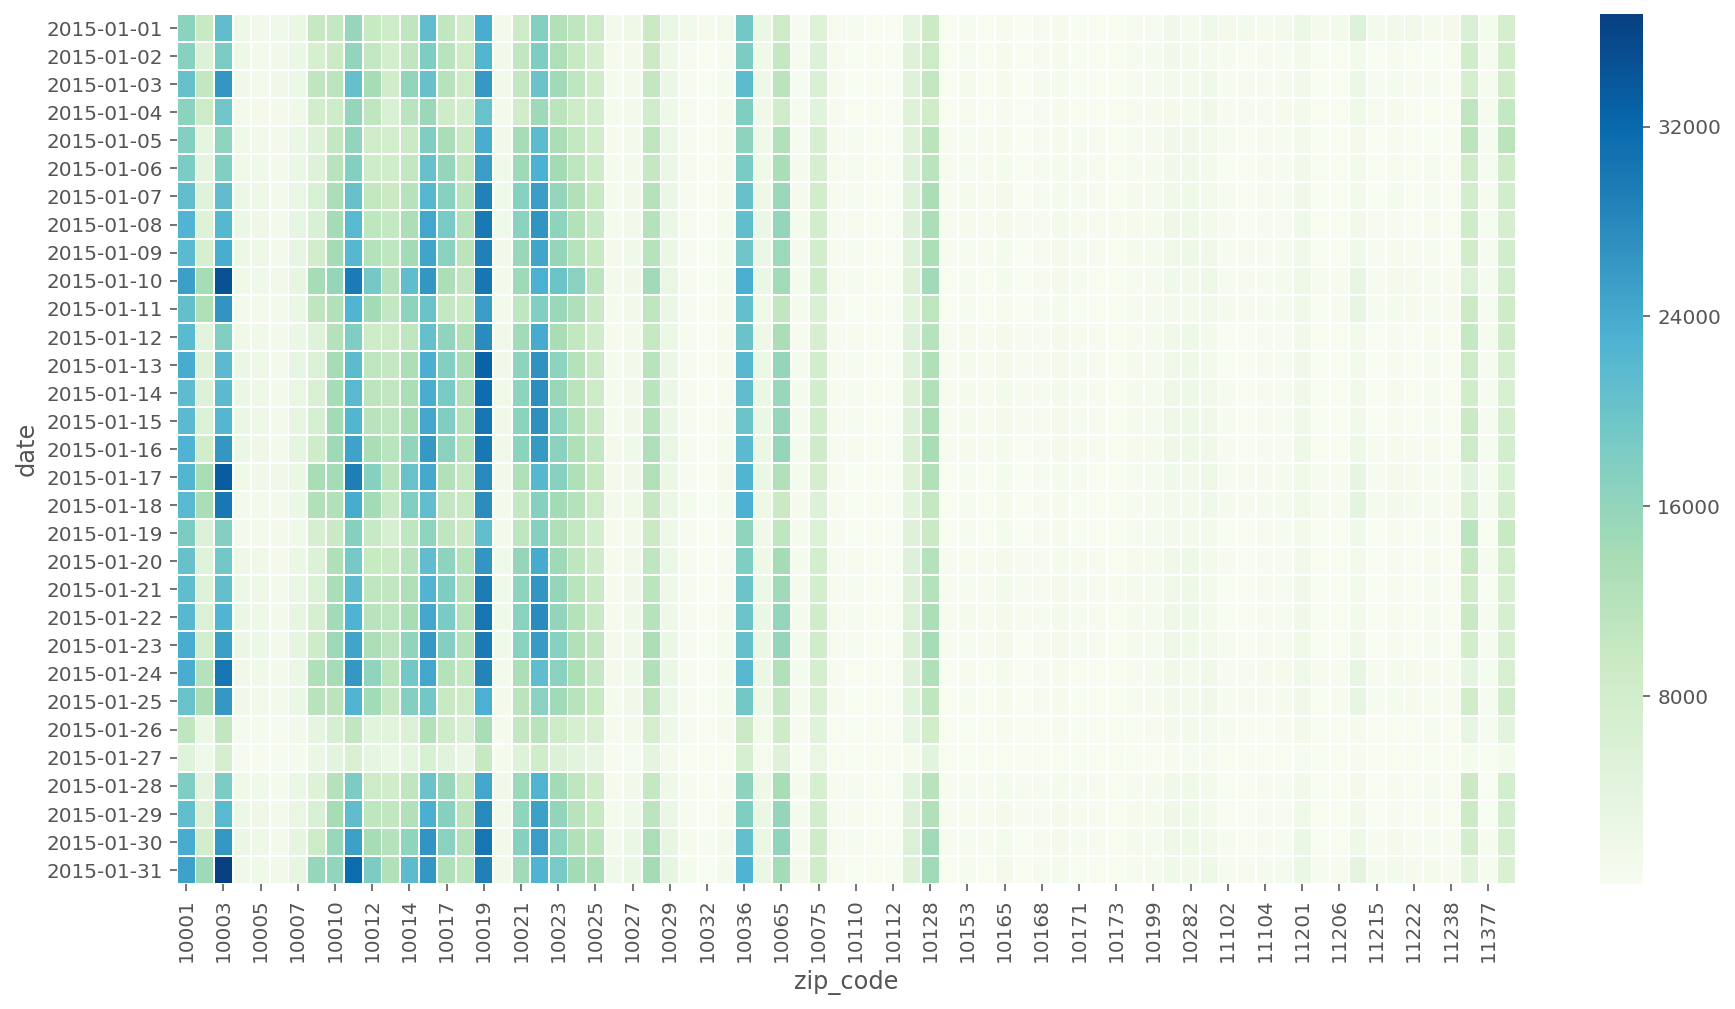

In [32]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),lw=.5, cmap='GnBu')

- 상대적으로 cnt 값이 높은 zip code 
    - 10001, 10003, 10011, 10015, 10019, 10022, 10036
- 위에 명시한 zip code 중, 10036을 제외한 나머지 지역은 시간의 흐름에 따라 cnt 패턴이 유사함
- 1.26 ~ 1.27은 눈사태로 인해 cnt 값이 현저히 떨어짐을 확인할 수 있음

### 시간 단위 zip_code별 Heatmap

In [33]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour
filter_zip_df.head(10)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,10152,"POLYGON((-73.972613 40.759059, -73.973068 40.7...",2015-01-01,15,2015-01-01,0
2,10280,"POLYGON((-74.019596 40.705638, -74.019603 40.7...",2015-01-01,54,2015-01-01,0
5,10199,"MULTIPOLYGON(((-73.99725 40.752083, -73.99768 ...",2015-01-01,20,2015-01-01,0
6,11101,"POLYGON((-73.96262 40.739033, -73.962609 40.73...",2015-01-01,96,2015-01-01,0
10,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01,1221,2015-01-01,0
11,11103,"MULTIPOLYGON(((-73.904137 40.76752, -73.904187...",2015-01-01,45,2015-01-01,0
12,10168,"POLYGON((-73.977677 40.752119, -73.978159 40.7...",2015-01-01,32,2015-01-01,0
13,10023,"POLYGON((-73.990149 40.772311, -73.989994 40.7...",2015-01-01,971,2015-01-01,0
17,10035,"MULTIPOLYGON(((-73.946325 40.800852, -73.94646...",2015-01-01,92,2015-01-01,0
18,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",2015-01-01,432,2015-01-01,0


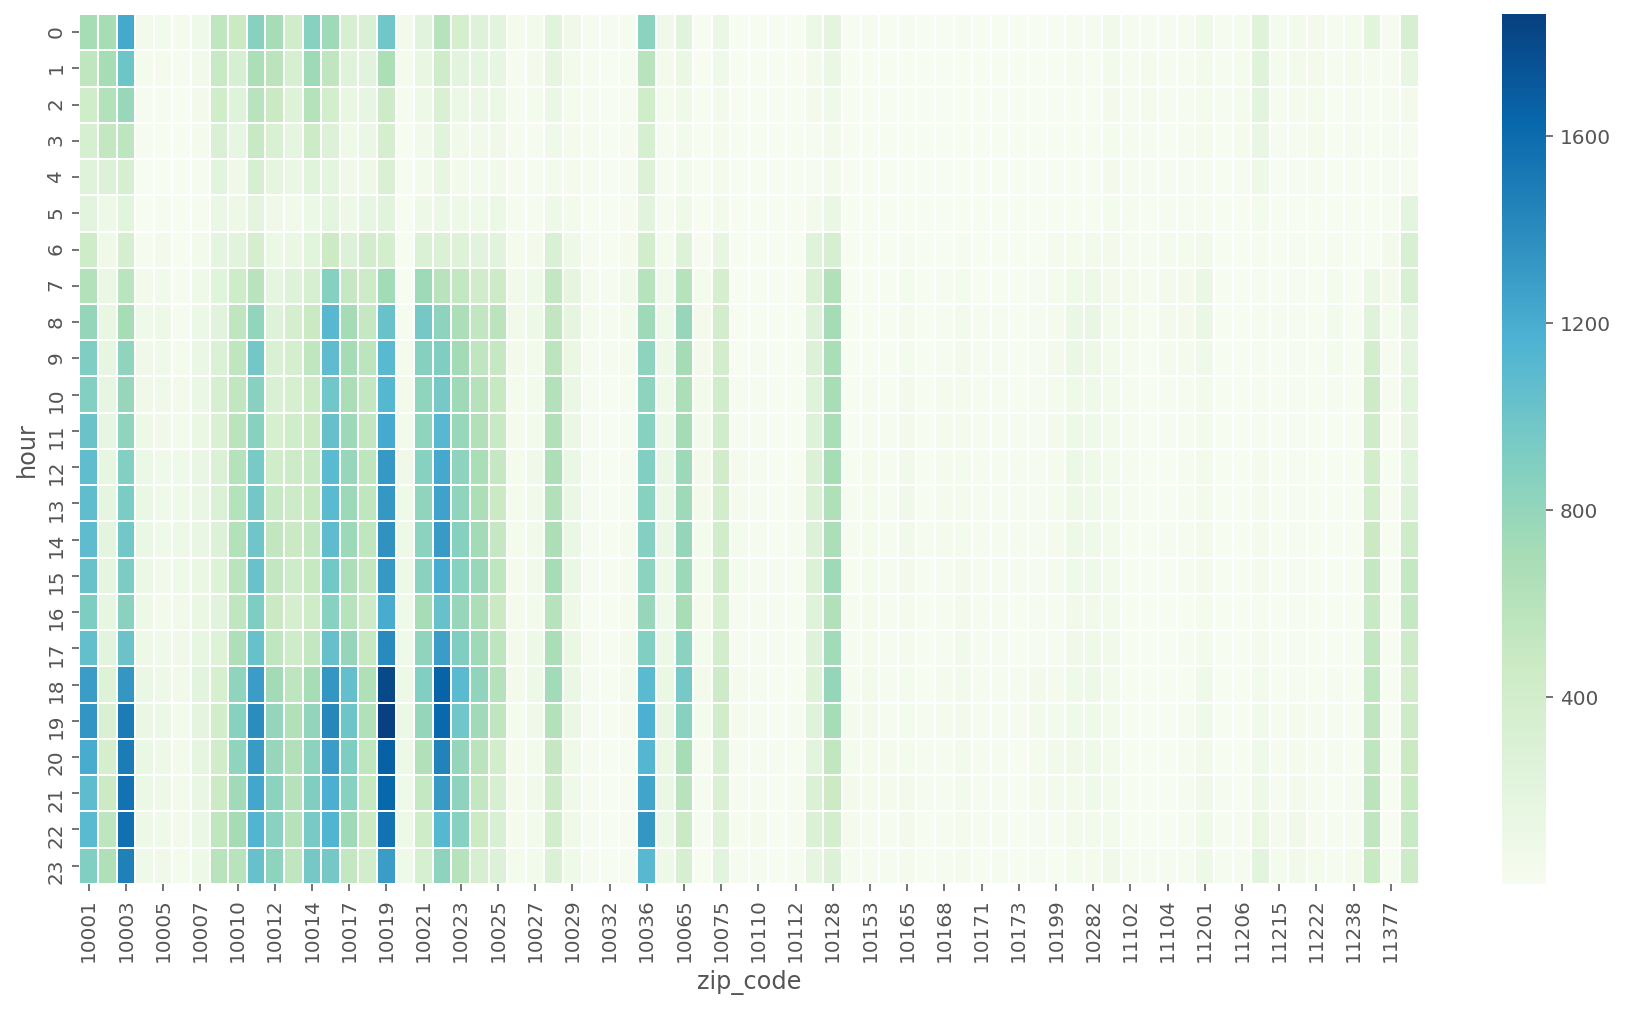

In [34]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table(values='cnt', index='hour', columns='zip_code', aggfunc=np.mean),lw=.5, cmap='GnBu')

- 18 ~ 19시 사이에 cnt 값이 주로 높은 것을 확인할 수 있음
- 10003, 10019 구역의 경우, 20 ~ 23시에도 cnt 값이 높은 편이며, 10019의 경우 전반적으로 cnt 값이 높음